# bigsimr tutorial
## Installation
### Julia installation
To install Julia on your machine, you can follow the instruction at Julia website at https://julialang.org/downloads/. Julia can also be installed in linux using the script below. It will create a folder named julia in the home folder and add necessary PATH to .bashrc file.

In [1]:
# ! mkdir ~/julia
# ! wget https://julialang-s3.julialang.org/bin/linux/x64/1.5/julia-1.5.3-linux-x86_64.tar.gz -O ~/julia/julia-1.5.3-linux-x86_64.tar.gz
# ! tar zxvf ~/julia/julia-1.5.3-linux-x86_64.tar.gz -C ~/julia
# ! echo "export PATH='$PATH:$HOME/julia/julia-1.5.3/bin'" >> ~/.bashrc

## bigsimr installation
Install bigsimr and julia packages from pip using these commands. julia package is used to communicate with Julia from python.

In [2]:
# ! pip install git+https://github.com/SchisslerGroup/python-bigsimr.git

# Or dev version

# ! pip install git+https://github.com/SchisslerGroup/python-bigsimr.git@dev

# ! pip install julia

After that, setup function can be used to installed the necessary Julia packages for bigsimr.

In [3]:
# from bigsimr import setup
# setup()

## Simulation example
### Importing necessary dependencies
This line can be removed for better performance. However, it can lead to error in some system.
>jl = Julia(compiled_modules=False)

In [4]:
from julia.api import Julia

jl = Julia(compiled_modules=False)

from julia import Bigsimr, Distributions

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, lognorm

We're going to show the basic use and syntax of `Bigsimr` by using the New York air quality data set (`airquality`). We will focus specifically on the temperature (degrees Fahrenheit) and ozone level (parts per billion).

In [5]:
df = pd.read_csv('airquality.csv')
df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


In [6]:
df = df[['Ozone', 'Temp']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,Ozone,Temp
0,41.0,67
1,36.0,72
2,12.0,74
3,18.0,62
4,28.0,66
...,...,...
111,14.0,63
112,30.0,70
113,14.0,75
114,18.0,76


Let's look at the joint distribution of the Ozone and Temperature

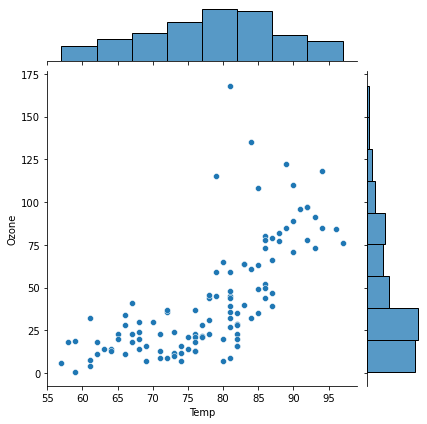

In [7]:
sns.jointplot(x=df['Temp'], y=df['Ozone'], kind='scatter', cmap="viridis")
plt.show()

To estimate the Pearson correlation, we can use the convenience function `Bigsimr.cor_fast`.

In [8]:
rho = Bigsimr.cor_fast(df.values)
print('Correlation of input data:')
rho

Correlation of input data:


array([[1.        , 0.69836034],
       [0.69836034, 1.        ]])

Next, we can estimate the marginal parameters, assuming that `Temperature` is normally distributed, and `Ozone` is log-normally distributed.

In [9]:
ozone = df['Ozone'].values
print('Ozone summary: logmean = {0:.2f}, logsd = {1:.2f}'.format(
    np.mean(np.log(ozone)), 
    np.std(np.log(ozone))
))

temp = df['Temp'].values
print('Temperature summary: mean = {0:.2f}, sd = {1:.2f}'.format(
    np.mean(temp), 
    np.std(temp)
))

Ozone summary: logmean = 3.42, logsd = 0.86
Temperature summary: mean = 77.87, sd = 9.44


In [10]:
#Define margins
margins = [
    Distributions.LogNormal(3.42, 0.86),
    Distributions.Normal(77.84, 9.44)
]

Next, we can generate the simulated data with or without Pearson matching. The data simulated with Pearson matching has correlation closer to the real data.

In [11]:
rv = Bigsimr.rvec(10000, rho, margins)

print('Correlation of simulated data without Pearson matching:')
print(Bigsimr.cor_fast(rv))

Correlation of simulated data without Pearson matching:
[[1.         0.57424863]
 [0.57424863 1.        ]]


In [12]:
D = Bigsimr.MvDistribution(rho, margins, Bigsimr.Pearson)
D = Bigsimr.pearson_match(D)
rho_match = Bigsimr.cor_convert(Bigsimr.cor(D), Bigsimr.cortype(D), Bigsimr.Pearson)
rho_match = Bigsimr.cor_nearPD(rho_match)
rv = Bigsimr.rvec(10000, rho_match, Bigsimr.margins(D))

print('Correlation of simulated data with Pearson matching:')
print(Bigsimr.cor_fast(rv))

Correlation of simulated data with Pearson matching:
[[1.         0.70464789]
 [0.70464789 1.        ]]


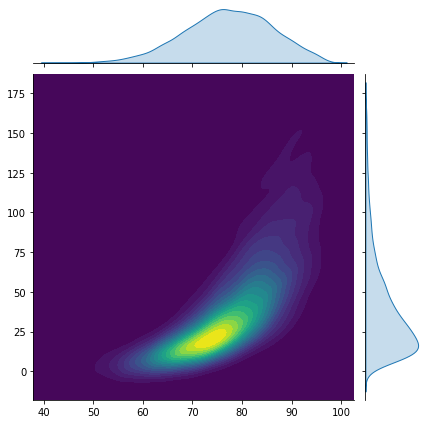

In [13]:
rv = rv[(rv[:,0]>0) & (rv[:,0]<ozone.max()) & (rv[:,1]>0) & (rv[:,1]<temp.max()), :]

sns.jointplot(x=rv[:,1], y=rv[:,0], kind='kde', cmap="viridis", fill=True, thresh=0, levels=20)
plt.show()

We can compare the bivariate distribution above to one where no correlation is taken into account.

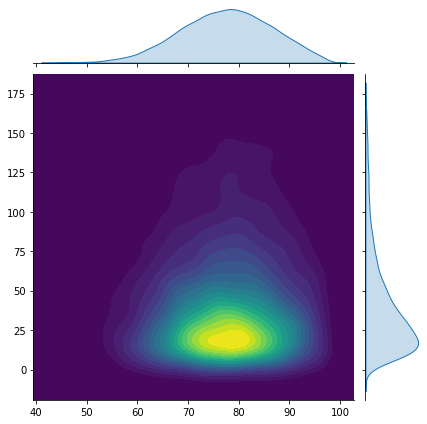

In [14]:
np.random.seed(1)
rv = np.stack([
    lognorm.rvs(size=10000, s=0.86, scale=np.exp(3.42)),
    norm.rvs(size=10000, loc=77.87, scale=9.44)
], 1)

rv = rv[(rv[:,0]>0) & (rv[:,0]<ozone.max()) & (rv[:,1]>0) & (rv[:,1]<temp.max()), :]

sns.jointplot(x=rv[:,1], y=rv[:,0], kind='kde', cmap="viridis", fill=True, thresh=0, levels=20)
plt.show()








